1. We will consider the prices between 0 and 1
2. We will consider amount of stocks between 0 and 1.
3. Reward at the terminal state will be calculated.

## Consider following variabes as state of the system

Our state is comprised of price, stocks available, last dark pool execution, last dark pool order, time

$p_t = $ price in market order at $t$

$ X_t = $ stocks available to sell at time $t$

$ z_t = $ stocks applied to sell at time $t$ in dark pool

$ y_t = $ stcoks executed in dark pool at time $t$

$ x_t = $ stcoks applied as market orders at time $t$

the state will be vector $ v = [p_t, X_t, y_{t-1},z_{t-1},, t]$

We will consider following feature vector on the state for value function
$$ f_s = [X_tp_t, (y_{t-1})p_t, X_t^2, p_t^2, y_{t-1}] $$


## Different feature set for action in dark pool and market orders

Market Order Policy Feature Vector
$$ f_m = [\sqrt(p_tX_t), 0.1p_t, 0.01X_t^2] $$

Dark Pool Order Policy Feature Vector
$$ f_d = [\sqrt(p_tX_t), y_{t-1}, X_{t-1}] $$


We will consider the value function as the linear function as
$$V(f_s,\theta) = \theta_1 f_{s_1} + \theta_2 f_{s_2} + \theta_3 f_{s_3} + \theta_4 f_{s_4} + \theta_5 f_{s_5} $$

Hence we need only $\theta = [\theta_1,\theta_2,\theta_3,\theta_4, \theta_5] $ as parameters for value function.

Simlarlry we will consider parametric form of policy for both dark pool as well as market orders as given below, 
$$\pi_m(f_m,\phi_m) = \phi_{m_1} f_{m_1} + \phi_{m_1} f_{m_2} + \phi_{m_3} f_{m_3} $$
$$\pi_d(f_m,\phi_d) = \phi_{d_1} f_{d_1} + \phi_{d_1} f_{d_2} + \phi_{d_3} f_{d_3} $$

Our policy set will be
$$ \prod = [(\pi_{m_1}, \pi_{d_1}), (\pi_{m_2}, \pi_{d_2}), ..........,(\pi_{m_{T-1}}, \pi_{d_{T-1}})] $$

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Lets first consider the dynamics of the system, lets make this final it looks okay.

def getImpactPrice(price, amount):
    if amount < 0.1:
        p = max(price*(1-0.008*amount), 0)
    elif amount < 0.5:
        p = max(price*(1-0.04*amount*amount), 0)
    else:
        p = max(price*(1-0.08*amount*amount*amount), 0)
    return p

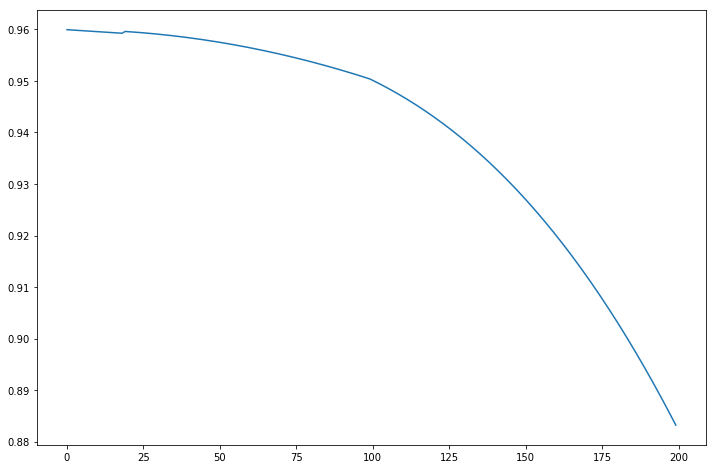

In [3]:
price = 0.96
prices = [ getImpactPrice(price, 0.005*i) for i in range(1,201)]
# this looks okay.
plt.figure(figsize=(12, 8))
plt.plot(prices)

In [4]:
# to add the random component in the price
def addRandom(price):
    p = min(1, max(0, price + np.random.normal(0.01, 0.01)))
    return p

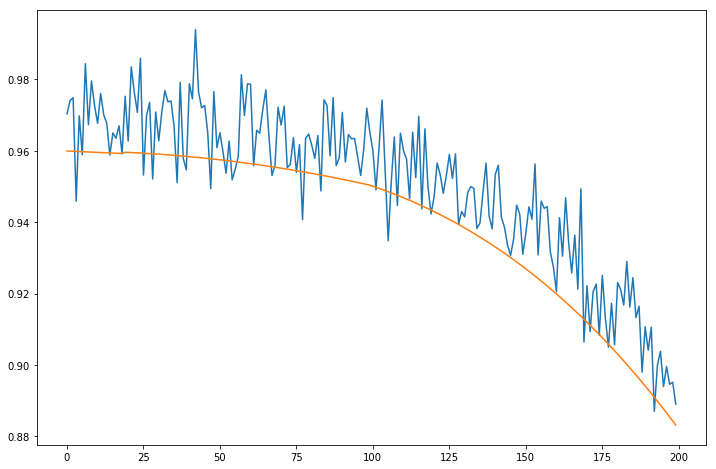

In [5]:
# this also looks okay
rp = [addRandom(p) for p in prices]
plt.figure(figsize=(12, 8))
plt.plot(rp)
plt.plot(prices)

In [6]:
def getStateFeatures(state):
    feat = np.random.random(5)
    feat[0] = state[0]*state[1]
    feat[1] = state[0]*state[2]
    feat[2] = state[1]*state[1]
    feat[3] = state[0]*state[0]
    feat[4] = state[2]
    return feat

In [7]:
def getMarketFeat(state):
    featMarket = np.random.random(3)
    featMarket[0] = np.sqrt(state[0]*state[1])
    featMarket[1] = 0.1*state[0]
    featMarket[2] = 0.01*state[1]*state[1]
    return featMarket

In [8]:
def getDarkFeat(state):
    featDark = np.random.random(3)
    featDark[0] = np.sqrt(0.001*state[0]*state[1])
    featDark[1] = state[2]
    featDark[2] = state[1]
    
    return featDark

In [9]:
def getDarkPrice(price):
    return max(0, price - np.random.normal(0.01, 0.01))

In [10]:
# lets implement the parametric form of policy function as logistic regression, 
# since we want to apply order in between (0,1)

def getAction(state, param):
    '''param is 3d parameter parameter vector and state is 3d vector of state, it returns the value of softmax 
    function/logistic regression based on state and param'''
    featMarket = getMarketFeat(state)
    featDark = getDarkFeat(state)
    val = [0,0]
    val[0] = 1/(1+ np.exp(np.dot(param[0], featDark)))
    val[1] = 1/(1+np.exp(np.dot(param[1], featMarket)))
    return val


In [11]:
def getRewardState(state, action):
    '''it takes current state and action, returns next state and reward generated in this state'''
    newState = [0 for s in state]
    #print('action: ', action)
    price = getImpactPrice(state[0], state[1]*action[1])
    darkPrice = getDarkPrice(state[0])
    darkFrac = np.random.random()
    darkExec = darkFrac*action[0]*state[1]
    reward = darkExec*darkPrice + (state[1] - darkExec)*action[1]*price
    newState[0] = addRandom(price)
    newState[1] = max(state[1] - (state[1] - darkExec)*action[1], 0)
    newState[2] = darkFrac
    
    return (reward, newState)

In [12]:
# lets define function to calculate the state value function based on parameters of it
def getStateValue(state, param):
    stateFeat = getStateFeatures(state)
    value = np.dot(stateFeat, param)
    return value

In [13]:
# function to get the terminal reward
def getTerminalReward(state):
    ''' This function will return terminal reward based on terminal state provide'''
    price = getImpactPrice(state[0], state[1])
    reward = price*state[1]
    return reward

In [14]:
# implenting actor critic method, lets see if it converges or not
# we will consider that we have set of parameters for each time index
T = 20
#parameter set for state value function

theta = [np.random.random(5) for i in range(T-1)]
#parameter set for policy function
phi_market = [np.random.random(3) for i in range(T-1)]
phi_dark = [np.random.random(3) for i in range(T-1)]

# learning rate for policy function as well as value function is put to be 0.001 initially
alphaValue = 0.05
alphaMarket = 0.01
alphaDark = 0.02

# as general rule of thumb is to put lambda value as 0.9 in TD(lambda) algo, I would put the same here
lambbda = 0.8

In [16]:
# now lets implement the actor critic method here and see if it works or not
# let us take number of iterations as 10000 initially and then we will see later if it works
N = 1
while N <= 50000:
    # generate the initial state and start state = [price, stocks, 1]
    state = [np.random.random(), np.random.random(), np.random.random()]
    z = np.random.random(5)
    t = 0
    while t < (T-1) and state[1] > 0.000001:
        # get the action to apply based on the policy we have till now
        action = getAction(state, [phi_dark[t], phi_market[t]])
        random = np.random.random()
        exploreDark = 1.0
        exploreMarket = 1.0
        if random <= 0.08:
            exploreMarket = np.random.normal(0, 0.001)
            exploreDark = np.random.normal(0, 0.001)
            action[0] = action[0] + exploreDark
            action[1] = action[1] + exploreMarket
        (reward, newState) = getRewardState(state, action)
        # based on above get the delta error value as below
        stateVal = getStateValue(state, theta[t])
        if t == T-2:
            delta = reward + getTerminalReward(newState) - stateVal
        else:
            delta = reward + getStateValue(newState, theta[t+1]) - stateVal
        #now update the set of parameters that is theta and nu
        z = np.add(np.multiply(lambbda, z), getStateFeatures(state))
        theta[t] = np.add(theta[t], np.multiply(alphaValue*delta, z))
        phi_dark[t] = np.add(phi_dark[t], np.multiply(alphaDark*delta*stateVal*(1-stateVal)*exploreDark, getDarkFeat(state)))
        phi_dark[t] = np.add(phi_dark[t], np.multiply(alphaMarket*delta*stateVal*(1-stateVal)*exploreMarket, getMarketFeat(state)))
        state = newState
        t = t + 1
    N = N + 1
print('learning completed')

learning completed


In [17]:
# lets print parameters of value function over time
for t in range(T-1):
    print('theta:\t', theta[t])
    print('phi_dark:\t',phi_dark[t])
    print('phi_market:\t',phi_market[t])

theta:	 [ 1.42405167 -0.07327683  0.03015142  0.08614394  0.00266465]
phi_dark:	 [ 0.59955182  0.80043525  1.04516669]
phi_market:	 [ 0.27485009  0.17463003  0.05251533]
theta:	 [  1.53587416e+00  -2.60254925e-02   9.63913329e-02   4.10110477e-02
  -1.23743468e-03]
phi_dark:	 [ 0.74914492  0.63835361  0.41288504]
phi_market:	 [ 0.86614147  0.67549535  0.73553553]
theta:	 [ 1.48135211 -0.00566799  0.21506131  0.03766973 -0.00678986]
phi_dark:	 [ 0.12301578  0.31347874  0.64077949]
phi_market:	 [ 0.80283272  0.14038036  0.36784495]
theta:	 [  1.40849299e+00   4.10761833e-03   4.00634601e-01   2.74032202e-02
   2.68475977e-04]
phi_dark:	 [ 0.89792253  0.29263245  0.88126439]
phi_market:	 [ 0.83839029  0.31064946  0.15804719]
theta:	 [  1.36735720e+00   2.57856468e-03   6.23446686e-01   2.04289729e-02
  -4.62872778e-04]
phi_dark:	 [ 0.89336057 -0.01195146  0.47533113]
phi_market:	 [ 0.72281106  0.50624307  0.38661746]
theta:	 [  1.28313030e+00  -2.92045591e-03   8.03630876e-01   1.73081388

In [18]:
# as per the above parameters let's check what is the output
def actionValue():
    darkAction = [0 for i in range(20)]
    marketAction = [0 for i in range(20)]
    val = [0 for i in range(20)]
    prices = [0 for i in range(20)]
    T = 20
    #for i in range(1000):
    value = 0.0
    s_t = [np.random.random(), np.random.random(), np.random.random()]
    print(s_t)
    t = 0
    while t < T and s_t[1] > 0:
        if t == T-1:
            #u_t = s_t[1]
            val[t] = getTerminalReward(s_t)
            darkAction[t] = 0
            marketAction[t] = 1.0
        else:
            #u_t0 = np.random.normal(5,5)
            (darkAction[t], marketAction[t]) =  getAction(s_t, [phi_dark[t], phi_market[t]])
            (reward, s) = getRewardState(s_t, [darkAction[t], marketAction[t]])
            val[t] = np.dot(getStateFeatures(s_t), theta[t])
        prices[t] = s_t[0]
        s_t = s
        t = t + 1
    print(t)
    return (val, darkAction, marketAction, prices)

In [24]:
# after 10000 iterations
(values, actionD, actionM, prices) = actionValue()

[0.7306160720671534, 0.94021504896769, 0.9558379815197597]
20


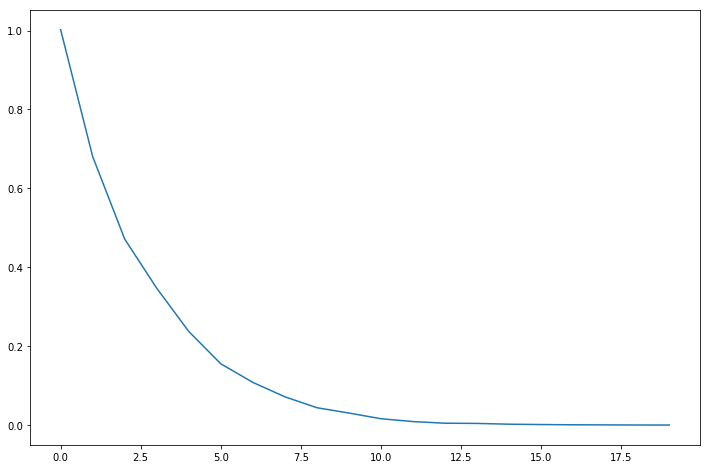

In [25]:
plt.figure(figsize=(12,8))
plt.plot(values)
#print(values)

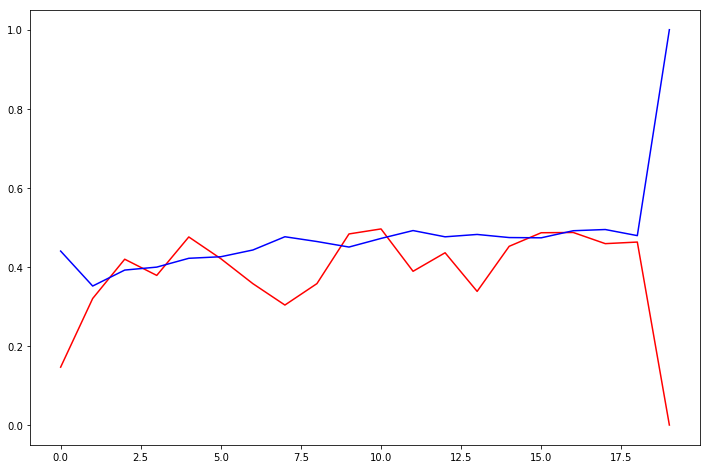

In [26]:
plt.figure(figsize=(12,8))
plt.plot(actionD, 'r-')
plt.plot(actionM, 'b-')
#print(actions)

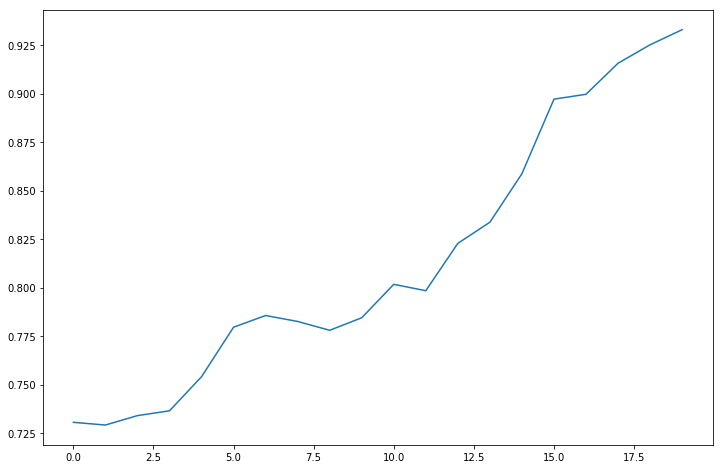

In [27]:
plt.figure(figsize=(12,8))
plt.plot(prices)

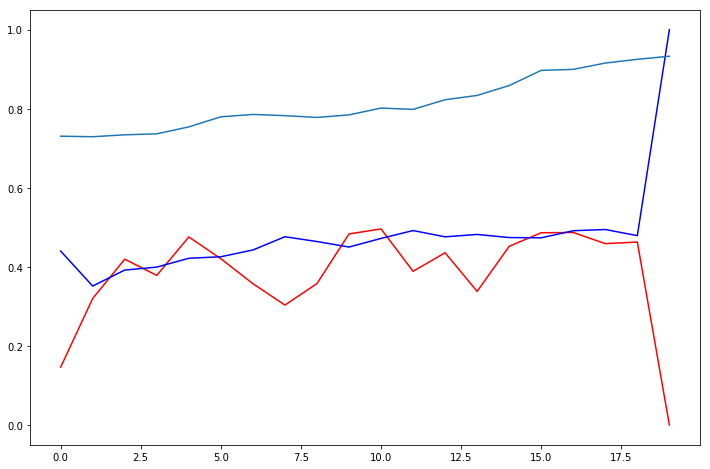

In [28]:
plt.figure(figsize=(12,8))
plt.plot(actionD, 'r-')
plt.plot(actionM, 'b-')
plt.plot(prices)
#print(actions)

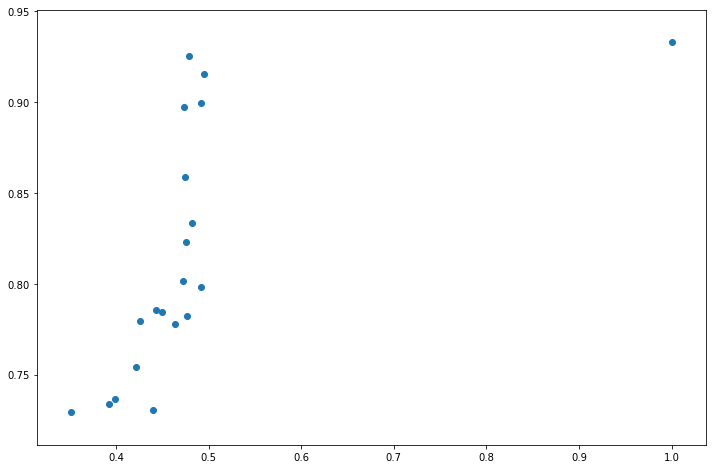

In [29]:
plt.figure(figsize=(12,8))
plt.scatter(actionM, prices)

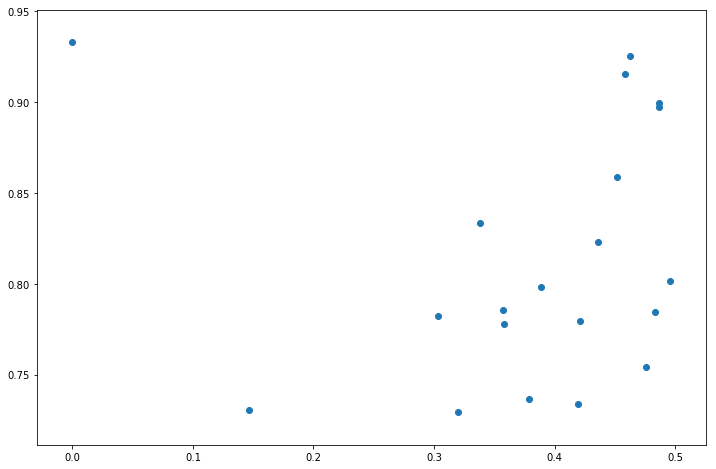

In [30]:
plt.figure(figsize=(12,8))
plt.scatter(actionD, prices)